In [5]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import torch
import torch.nn.functional as F
from tqdm import tqdm, trange
from dotenv import load_dotenv
import os
from data_utils import load_from_json, save_to_json
from collections import defaultdict
from pprint import pprint

load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

c:\Arjun\Code\ai\toy_subtask_evals\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
MODEL_NAME = 'meta-llama/Meta-Llama-3-8B-Instruct'
model_id = 'llama3_8b'
# MODEL_NAME = 'meta-llama/Llama-2-7b-chat-hf'
# model_id = 'llama2_7b'
# MODEL_NAME = 'meta-llama/Llama-2-13b-chat-hf'
# model_id = 'llama2_13b'

MODEL_IDS = ['llama3_8b', 'llama2_13b', 'llama2_7b']
SYSTEM_PROMPT = """You are a machine that ONLY outputs individual words separated by spaces. You MUST begin each word with the same letter that ended the previous word. For example: "bird dublin november rascal laughing"
""".strip()
USER_PROMPT = """Your task: Produce a list that contains, in order, a one-word country, a one-word capital city of a country, a one-word US state, a one-word US state capital, and the surname of an American president."""
WORDS_IN_MOUTH = """ Here is the list:

"""

In [3]:
def load_model(model_name='gpt2'):
    """
    Loads a GPT2 model and its tokenizer.
    """
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.eval()  # Set the model to evaluation mode
    return tokenizer, model

def format_llama_prompt(model_name, user_prompt, system_prompt='You are a helpful assistant.', words_in_mouth=''):
    llama_3_model_names = ['llama3', 'meta-llama/Meta-Llama-3-8B-Instruct']
    llama_2_model_names = ['llama2', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-13b-chat-hf']
    assert model_name in llama_3_model_names + llama_2_model_names, f"Model name {model_name} not recognized."
    
    if model_name in llama_3_model_names:
        return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>

{user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{words_in_mouth}"""

    else: # Llama 2
        words_in_mouth = ' ' + words_in_mouth
        return f"""<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>
{user_prompt} [/INST]{words_in_mouth}"""


def load_llama_model(model_name):
    """
    Loads a Llama model and its tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN)
    model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                token=HF_TOKEN
            )

    return tokenizer, model


def get_top_k_token_probs(model, tokenizer, prompt, top_k=10, maximum_length=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=maximum_length,
            num_return_sequences=1,
            output_scores=True,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.eos_token_id,
            temperature=1,
            # do_sample=False,  # This ensures greedy decoding
            num_beams=1  # This enforces a single beam, which is equivalent to greedy decoding
        )

    # Get the generated tokens and scores
    generated_tokens = output.sequences[0]
    scores = output.scores

    results = []

    # Iterate through each output token (excluding the input)
    for i, token_id in enumerate(generated_tokens[input_ids.shape[1]:]):
        # Get the logits for the current step
        step_scores = scores[i]

        # Convert logits to probabilities using softmax
        probs = F.softmax(step_scores, dim=-1)

        # Get the top-k probabilities and their corresponding token IDs
        top_probs, top_indices = torch.topk(probs, k=top_k)

        # Convert token IDs to actual tokens
        top_tokens = [tokenizer.decode([idx.item()]) for idx in top_indices[0]]

        # Find the probability of the generated token
        gen_token_prob = probs[0][token_id].item()

        # Store the results for this step
        step_result = {
            "token": tokenizer.decode([token_id.item()]),
            "prob": gen_token_prob,
            "top_k_probs": [
                {"token": token, "probability": prob.item()}
                for token, prob in zip(top_tokens, top_probs[0])
            ]
        }
        results.append(step_result)

    return results

In [4]:
import re
def clean_llama2_13b_chain(chain):
    cleaned_chain = []
    for item in chain:
        # Remove the initial number and period, then remove anything within parentheses and extra hyphens
        clean_item = re.sub(r'\d+\.', '', item)  # Remove leading numbers and periods
        clean_item = re.sub(r'\(.*?\)', '', clean_item)  # Remove parentheticals
        clean_item = re.sub(r'[-]', '', clean_item)  # Remove hyphens
        cleaned_chain.append(clean_item.strip())
    return cleaned_chain

In [5]:
def produce_results(model, tokenizer, num_results):
    results = []
    prompt = format_llama_prompt(MODEL_NAME, USER_PROMPT, system_prompt=SYSTEM_PROMPT, words_in_mouth=WORDS_IN_MOUTH)
    for i in range(num_results):
        if i % (num_results // 10) == 0:
            print(i)

        output = get_top_k_token_probs(model, tokenizer, prompt, top_k=30, maximum_length = 200)

        message = ''
        tokens = [result['token'] for result in output]
        tokens = tokens[:-1] # Remove the last token, which is the end-of-text token
        message = ''.join(tokens)
        chain = message.lower().split()
        total_prob = 1
        for result in output:
            total_prob *= result['prob']
        # print(tokens, total_prob)
        results.append({
            'tokens': tokens,
            'total_prob': total_prob})

    try:
        existing_results = load_from_json(f"results/{model_id}_results.json")
    except FileNotFoundError:
        existing_results = []
    existing_results.extend(results)
    save_to_json(existing_results, f"results/{model_id}_results.json")
    print('Done!')

In [6]:
from typing import List
def chain_probability(model, tokenizer, chain: List[str]):
    """
    Calculates the total probability of a given sequence from a formatted prompt using the model's predictions.
    """
    prompt = format_llama_prompt(
        MODEL_NAME,
        USER_PROMPT,
        system_prompt=SYSTEM_PROMPT,
        words_in_mouth=''.join(chain),
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Tokenize the prompt
    tokens = tokenizer(prompt, return_tensors='pt')
    input_ids = tokens.input_ids.to(device)
    attention_mask = tokens.attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Convert logits to probabilities using softmax
    softmax = torch.nn.functional.softmax(logits, dim=-1)
    total_probability = 1.0

    # Start from the token where last N tokens begin
    chain_token_ids = tokenizer.encode(''.join(chain), add_special_tokens=False)
    end_index = input_ids.shape[1] - 1
    start_index = end_index - len(chain_token_ids)

    # Calculate the probability of each of the last N actual tokens

    for i in range(start_index, end_index):
        predicted_prob = softmax[0, i, input_ids[0, i+1]].item()
        total_probability *= predicted_prob
    return total_probability

In [7]:
""" Print total number of correct solution chains and the number of choosable items for each category """

solutions = load_from_json("solutions.json")

def build_last_letter_dict(strings):
    prefix_dict = defaultdict(list)
    for s in strings:
        prefix_dict[s[-1]].append(s)
    return prefix_dict

last_letter_dict_countries = build_last_letter_dict(solutions['countries'])
last_letter_dict_world_capitals = build_last_letter_dict(solutions['world_capitals'])
last_letter_dict_states = build_last_letter_dict(solutions['states'])
last_letter_dict_state_capitals = build_last_letter_dict(solutions['state_capitals'])

correct_chains = []
for p in solutions['presidents']:
    for result in last_letter_dict_state_capitals[p[0]]:
        for s in last_letter_dict_states[result[0]]:
            for w in last_letter_dict_world_capitals[s[0]]:
                for x in last_letter_dict_countries[w[0]]:
                    correct_chains.append([x, w, s, result, p])

print(f'Total number of correct chains: {len(correct_chains)}')
print('Examples:')
pprint(correct_chains[10000:10010])

choosable_countries = set([c[0] for c in correct_chains])
choosable_world_capitals = set([c[1] for c in correct_chains])
choosable_states = set([c[2] for c in correct_chains])
choosable_state_capitals = set([c[3] for c in correct_chains])
choosable_presidents = set([c[4] for c in correct_chains])
choosable = choosable_countries | choosable_world_capitals | choosable_states | choosable_state_capitals | choosable_presidents

print(f'Choosable countries: {len(choosable_countries)} / {len(solutions["countries"])}')
print(f'Choosable world capitals: {len(choosable_world_capitals)} / {len(solutions["world_capitals"])}')
print(f'Choosable states: {len(choosable_states)} / {len(solutions["states"])}')
print(f'Choosable state capitals: {len(choosable_state_capitals)} / {len(solutions["state_capitals"])}')
print(f'Choosable presidents: {len(choosable_presidents)} / {len(solutions["presidents"])}')

Total number of correct chains: 24686
Examples:
[['russia', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['rwanda', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['samoa', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['serbia', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['slovakia', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['slovenia', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['somalia', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['syria', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['tanzania', 'amsterdam', 'massachusetts', 'salem', 'monroe'],
 ['tonga', 'amsterdam', 'massachusetts', 'salem', 'monroe']]
Choosable countries: 152 / 182
Choosable world capitals: 118 / 209
Choosable states: 30 / 40
Choosable state capitals: 14 / 41
Choosable presidents: 12 / 39


In [8]:
def compute_golden_probs(model, tokenizer):
    chain_probs = []
    for chain in tqdm(correct_chains):
        token_list = [f' {word.capitalize()}' for word in chain]
        chain_probs.append([token_list, chain_probability(model, tokenizer, token_list)])
    chain_probs.sort(key=lambda x: x[1], reverse=True)
    save_to_json(chain_probs, f"golden_probs/{model_id}_chain_probs.json")

In [13]:
tokenizer, model = load_llama_model(MODEL_NAME)
compute_golden_probs(model, tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 24686/24686 [55:11<00:00,  7.45it/s]


In [10]:
for id in MODEL_IDS:
    results = load_from_json(f"results/{id}_results.json")
    golden_probs = load_from_json(f"golden_probs/{id}_chain_probs.json")

    print(f'== {id} ==')
    print('[Avg Probability = probability given to its own (wrong) outputs]')
    print(f'Avg Probability: {sum([result["total_prob"] for result in results]) / len(results)} (n={len(results)})')
    print(f'Avg Golden Prob: {sum([result[1] for result in golden_probs]) / len(golden_probs)} (n={len(golden_probs)})')
    print(f'Top Golden Prob: {golden_probs[0][1]}')
    print()

== llama3_8b ==
[Avg Probability = probability given to its own (wrong) outputs]
Avg Probability: 0.0008948663055290472 (n=1000)
Avg Golden Prob: 7.83418857351913e-06 (n=100)
Top Golden Prob: 0.0006891653831789729

== llama2_13b ==
[Avg Probability = probability given to its own (wrong) outputs]
Avg Probability: 0.02267308978812005 (n=1000)
Avg Golden Prob: 0.0002924728581509998 (n=24686)
Top Golden Prob: 0.2941987770125203

== llama2_7b ==
[Avg Probability = probability given to its own (wrong) outputs]
Avg Probability: 0.12097080941310683 (n=1000)
Avg Golden Prob: 7.985377891227602e-05 (n=24686)
Top Golden Prob: 0.06365389361491675



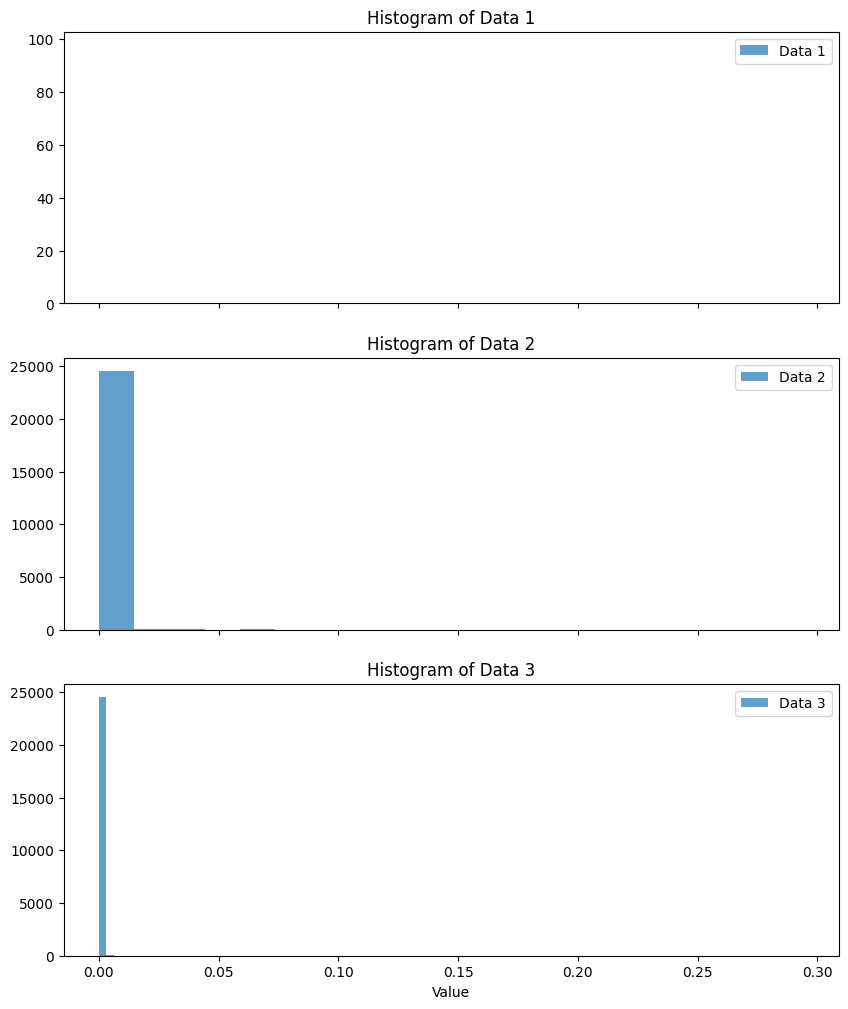

In [11]:
import matplotlib.pyplot as plt

lists = [[i[1] for i in load_from_json(f"golden_probs/{id}_chain_probs.json")] for id in MODEL_IDS]

num_data = len(lists)
fig, axes = plt.subplots(num_data, 1, figsize=(10, 4 * num_data), sharex=True)

# Plotting each histogram on a separate subplot
for i, data in enumerate(lists):
    axes[i].hist(data, bins=20, alpha=0.7, label=f'Data {i+1}')
    axes[i].set_title(f'Histogram of Data {i+1}')
    axes[i].legend()

plt.xlabel('Value')
plt.show()

In [6]:
for model in MODEL_IDS:
    print(f'== {model} ==')
    golden_probs = load_from_json(f"golden_probs/{model}_chain_probs.json")
    print(f'Sum: {sum([chain[1] for chain in golden_probs])}')
    print('Top 5 chains:')
    for chain in golden_probs[:5]:
        print(chain[0], chain[1])
    print()

== llama3_8b ==
Sum: 0.18628487704146918
Top 5 chains:
[' Andorra', ' Arequipa', ' Alabama', ' Atlanta', ' Adams'] 0.021691031967917485
[' Andorra', ' Arequipa', ' Alaska', ' Augusta', ' Adams'] 0.0175814359230185
[' Andorra', ' Arequipa', ' Arizona', ' Augusta', ' Adams'] 0.01571460584550844
[' Andorra', ' Arequipa', ' Alaska', ' Atlanta', ' Adams'] 0.011016500568821672
[' Abkhazia', ' Arequipa', ' Alabama', ' Atlanta', ' Adams'] 0.00962412162460146

== llama2_13b ==
Sum: 7.219984976315674
Top 5 chains:
[' Netherlands', ' Stockholm', ' Maryland', ' Denver', ' Roosevelt'] 0.2941987770125203
[' Albania', ' Amsterdam', ' Maryland', ' Denver', ' Roosevelt'] 0.276662861132429
[' Guinea', ' Amsterdam', ' Maryland', ' Denver', ' Roosevelt'] 0.23300613387878152
[' Philippines', ' Stockholm', ' Maryland', ' Denver', ' Roosevelt'] 0.19576340003895842
[' Austria', ' Amsterdam', ' Maryland', ' Denver', ' Roosevelt'] 0.19542319835953248

== llama2_7b ==
Sum: 1.971270386228446
Top 5 chains:
[' Mold